# $k$ Means

This section is the immediate extension from two means to $k$ means. 

The name ANOVA is sometimes used in this setting. ANOVA stands for analysis of analysis of variance, but should be more literally translated to comparing $k$ levels' means.  The reason behind the name ANOVA is that often, but not in this class, the variation amongst the groups compared to variation within the groups gives a reasonable decision rule for determinging when means by level are different.

We continue to work with the dataset $\texttt{carnivora}$.  Now we'll estimate a mean for $k = 4$ of the levels of the categorical variable $\texttt{Family}$: Canidae, Felidae, Mustelidae, and Viverridae. For the body weight data, $\texttt{SW}$, we assume

$$ Y_1, \ldots, Y_N \sim_{iid} \text{Normal}(\mu, \sigma^2) \\
\mu = \beta_0 + \beta_1 * Felidae + \beta_2 * Mustelidae + \beta_3 * Viverridae.$$

Let's plot our data and add the mean as a new layer, now that we're getting good at plotting.  The code below first carefully removes missing data and filters our dataset down to the levels of interest.

In [40]:
import numpy as np
import pandas as pd
import bplot as bp
from scipy.optimize import minimize
from scipy.stats import norm as normal
import patsy

bp.LaTeX()

In [2]:
carnivora = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/master/carnivora.csv")
carn = carnivora[carnivora['Family'].isin(["Canidae", "Felidae", "Mustelidae", "Viverridae"])]

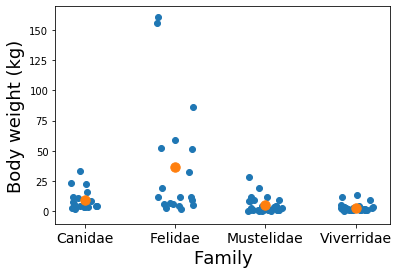

In [14]:
for i, (name, gdf) in enumerate(carn.groupby("Family")):
    y = gdf['SW']
    bp.jitter(np.repeat(i, y.size), y, jitter_y=0)
    bp.point(np.asarray([i]), y.mean(), color=bp.cat_color[1], size=1.5)
    
families = np.unique(carn['Family'])
bp.xticks(range(len(families)), labels=families, size=14)
bp.labels(x='Family', y='Body weight (kg)', size=18)

From the plot above, it seems like Felidae has the greatest mean weight, but it also seems like there is the most variation in Felidae.

### Example
Adapt the code above, along with the violin plot code from the two means section to make a violin plot for the four families above.

Code to fit our model above looks quite similar to our previous efforts in Sections Simple Linear Regression and Two Means.

In [23]:
def ll(beta, yX):
    y = yX[:, 0]
    X = yX[:, -4:]
    yhat = np.full(y.shape, np.nan)
    for r in range(X.shape[0]):
        yhat[r] = np.sum(beta * X[r,:])
    d = y - yhat
    return np.sum(d * d)

pX = patsy.dmatrix("~ C(Family)", data=carn)
yX = np.c_[carn["SW"], np.asarray(pX)]

beta = minimize(ll, normal.rvs(loc=10, size=4), args=(yX))["x"]

The same trick is taking place in our model.  The "intercept" is really the first level's mean, Canidae.  Each coefficient after that is a level-specific offset relative to Canidae's mean.  To find, say, Mustelidae's mean, you have to add $\hat{\beta}_0$ to $\hat{\beta}_2$.

In [28]:
np.round(beta[0] + beta[2], 3)

4.596

These estimates are still no different than group means.  Don't be discouraged, we are building to more complex models than group means.  Nonetheless, here's the empirical evidence.

In [27]:
(carn
 .groupby("Family")
 ["SW"]
 .agg("mean"))

Family
Canidae        9.511111
Felidae       36.458947
Mustelidae     4.595667
Viverridae     2.811250
Name: SW, dtype: float64

Quantifying uncertainty in our estimates is carried out with the bootstrap method.

In [55]:
N = carn['SW'].size
R = 999
betas = np.full((R, 4), np.nan)

for r in range(R):
    idx = np.random.choice(N, N)
    betas[r, :] = minimize(ll, normal.rvs(size=4), args=(yX[idx, :]))["x"]

/Users/ez/venvs/py3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/ez/venvs/py3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/ez/venvs/py3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/ez/venvs/py3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/ez/venvs/py3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/ez/venvs/py3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero enc

In [56]:
beta_p = np.percentile(betas, [10, 90], axis=0)

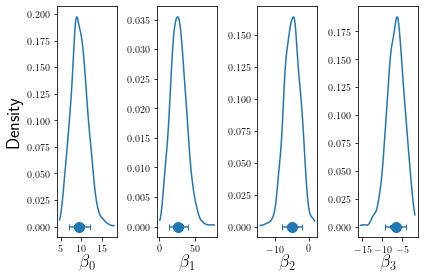

In [57]:
axs = bp.subplots(1, 4)

ylab = lambda i: "Density" if i < 1 else ""
xlab = lambda i: f"$\\beta_{ {i} }$"
for a in range(len(axs)):
    bp.current_axis(axs[a])
    bp.density(betas[:, a])
    bp.percentile_h(betas[:, a], y=0)
    bp.rug(beta_p[:, a])
    bp.labels(x=xlab(a), y=ylab(a), size=18)
    
bp.tight_layout()

In [58]:
beta_p

array([[ 6.99005835, 14.09121455, -7.75871771, -9.32626222],
       [12.17099575, 41.13387438, -1.93307932, -4.08192669]])